<a href="https://colab.research.google.com/github/Santoscarolinac/Rota-Inteligente---AI/blob/main/Rota_Inteligente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Célula 1: Instalação das bibliotecas necessárias
!pip install pandas networkx scikit-learn matplotlib
print("Bibliotecas instaladas com sucesso!")

Bibliotecas instaladas com sucesso!


In [ ]:
# Célula 2: Importação das bibliotecas
import os
import pandas as pd
import networkx as nx
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

print("Bibliotecas importadas.")

Bibliotecas importadas.


In [ ]:
# Célula 3: Criar diretórios e arquivos de dados
# Criar a pasta /data
!mkdir -p data
!mkdir -p outputs

# --- Criar /data/nos_mapa.csv ---
# (id_no, lat, lon)
# Simulando um mapa em grade (grid) 3x3
nos_content = """id_no,lat,lon
1,0,2
2,1,2
3,2,2
4,0,1
5,1,1
6,2,1
7,0,0
8,1,0
9,2,0
"""
with open("data/nos_mapa.csv", "w") as f:
    f.write(nos_content)

# --- Criar /data/arestas_mapa.csv ---
# (origem, destino, distancia)
# Conectando os nós da grade
arestas_content = """origem,destino,distancia
1,2,1
1,4,1
2,1,1
2,3,1
2,5,1
3,2,1
3,6,1
4,1,1
4,5,1
4,7,1
5,2,1
5,4,1
5,6,1
5,8,1
6,3,1
6,5,1
6,9,1
7,4,1
7,8,1
8,5,1
8,7,1
8,9,1
9,6,1
9,8,1
"""
with open("data/arestas_mapa.csv", "w") as f:
    f.write(arestas_content)

# --- Criar /data/pedidos_exemplo.csv ---
# (id_pedido, lat, lon)
# Pedidos espalhados pelo mapa
pedidos_content = """id_pedido,lat,lon
1001,0.1,1.9
1002,2.1,1.9
1003,0.1,0.1
1004,2.0,0.1
1005,1.1,2.1
1006,0.9,0.2
1007,1.8,1.1
1008,0.2,0.8
"""
with open("data/pedidos_exemplo.csv", "w") as f:
    f.write(pedidos_content)

print("Arquivos de dados simulados criados em /data/")

Arquivos de dados simulados criados em /data/


In [ ]:
# Célula 4: Funções de Grafo (grafo.py)

def carregar_grafo(path_nos, path_arestas):
    """
    Carrega o grafo da cidade a partir dos arquivos CSV usando NetworkX.
    """
    G = nx.Graph()

    # Carregar Nós (com posições lat/lon)
    df_nos = pd.read_csv(path_nos)
    for _, row in df_nos.iterrows():
        G.add_node(row['id_no'], pos=(row['lon'], row['lat'])) # (x, y) para plotting

    # Carregar Arestas (com peso 'distancia')
    df_arestas = pd.read_csv(path_arestas)
    for _, row in df_arestas.iterrows():
        G.add_edge(row['origem'], row['destino'], weight=row['distancia'])

    print(f"Grafo carregado: {G.number_of_nodes()} nós, {G.number_of_edges()} arestas.")
    return G

def encontrar_no_mais_proximo(G, lat, lon):
    """
    Encontra o nó do grafo mais próximo de uma coordenada (lat, lon) específica.
    Isso é usado para "encaixar" um pedido no mapa.
    """
    nos_pos = nx.get_node_attributes(G, 'pos')
    dist_minima = float('inf')
    no_proximo = None

    # Posições em (lon, lat) -> (x, y)
    for no, pos in nos_pos.items():
        dist = np.sqrt((pos[0] - lon)**2 + (pos[1] - lat)**2)
        if dist < dist_minima:
            dist_minima = dist
            no_proximo = no

    return no_proximo

def heuristica_a_star(u, v, G):
    """
    Função heurística para o A* (distância Euclidiana/em linha reta).
    O NetworkX usa o atributo 'pos' (x, y) que definimos como (lon, lat).
    """
    (lon1, lat1) = G.nodes[u]['pos']
    (lon2, lat2) = G.nodes[v]['pos']
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

In [ ]:
# Célula 5: Funções de Clustering (clustering.py)

def agrupar_pedidos(df_pedidos, num_clusters):
    """
    Aplica o K-Means para agrupar pedidos com base na lat/lon.
    """
    if df_pedidos.empty:
        print("Nenhum pedido para agrupar.")
        return df_pedidos

    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    coordenadas = df_pedidos[['lat', 'lon']]
    df_pedidos['cluster'] = kmeans.fit_predict(coordenadas)

    print(f"Pedidos agrupados em {num_clusters} clusters.")
    return df_pedidos

def visualizar_clusters(df_pedidos, restaurante_pos):
    """
    Mostra um gráfico de dispersão (scatter plot) dos pedidos e seus clusters.
    """
    plt.figure(figsize=(10, 7))
    # Posições em (lon, lat)
    plt.scatter(df_pedidos['lon'], df_pedidos['lat'], c=df_pedidos['cluster'], cmap='viridis', label='Pedidos')
    plt.scatter(restaurante_pos[0], restaurante_pos[1], color='red', marker='s', s=100, label='Restaurante (Sabor Express)')

    plt.title('Agrupamento de Pedidos (K-Means)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.savefig('outputs/clusters_pedidos.png')
    plt.show()

In [ ]:
# Célula 6: Funções de Roteamento (pathfinding.py)

def calcular_custo_rota(G, rota):
    """Calcula o custo total (distância) de uma rota."""
    custo_total = 0
    for i in range(len(rota) - 1):
        # Usamos A* para encontrar o caminho e seu custo
        # O peso 'weight' é a 'distancia' que definimos nas arestas
        custo_segmento = nx.astar_path_length(G, rota[i], rota[i+1], weight='weight', heuristic=lambda u, v: heuristica_a_star(u,v,G))
        custo_total += custo_segmento
    return custo_total

def ordenar_rota_tsp_nn(G, nos_visitar, no_inicio):
    """
    Calcula a ordem de visita usando a heurística do Vizinho Mais Próximo (TSP-NN).
    """
    if not nos_visitar:
        return [no_inicio, no_inicio], 0 # Rota de volta imediata

    rota_final = [no_inicio]
    nao_visitados = set(nos_visitar)
    no_atual = no_inicio

    while nao_visitados:
        proximo_no = None
        dist_minima = float('inf')

        # Encontra o nó não visitado mais próximo do nó atual
        for no in nao_visitados:
            # Calcula a distância real no grafo usando A*
            dist = nx.astar_path_length(G, no_atual, no, weight='weight', heuristic=lambda u, v: heuristica_a_star(u,v,G))
            if dist < dist_minima:
                dist_minima = dist
                proximo_no = no

        # Adiciona o nó mais próximo à rota
        rota_final.append(proximo_no)
        nao_visitados.remove(proximo_no)
        no_atual = proximo_no

    # Adiciona o retorno ao restaurante
    rota_final.append(no_inicio)

    # Calcula o custo total da rota otimizada
    custo_total = calcular_custo_rota(G, rota_final)

    return rota_final, custo_total

def visualizar_rota_no_grafo(G, rota, cluster_id):
    """
    Desenha o grafo e destaca uma rota específica.
    """
    pos = nx.get_node_attributes(G, 'pos')
    nos_rota = set(rota)

    # Cores
    cor_nos = ['#FF5733' if n in nos_rota else '#1f78b4' for n in G.nodes()]
    cor_arestas = ['#FF5733' if (u in nos_rota and v in nos_rota) else '#d3d3d3' for u, v in G.edges()]

    plt.figure(figsize=(12, 8))

    # Desenha o grafo
    nx.draw(G, pos, with_labels=True, node_color=cor_nos, edge_color=cor_arestas, node_size=300, font_size=10)

    # Destaca a rota com arestas mais grossas
    arestas_rota = list(zip(rota[:-1], rota[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=arestas_rota, width=3.0, edge_color='red')

    # Destaca o restaurante
    nx.draw_networkx_nodes(G, pos, nodelist=[rota[0]], node_color='green', node_shape='s', node_size=500)

    plt.title(f'Rota Otimizada para Cluster {cluster_id}')
    plt.savefig(f'outputs/rota_cluster_{cluster_id}.png')
    plt.show()

--- INICIANDO SOLUÇÃO ROTA INTELIGENTE ---
Grafo carregado: 9 nós, 12 arestas.

--- FASE 1: AGRUPANDO PEDIDOS ---
Pedidos agrupados em 3 clusters.


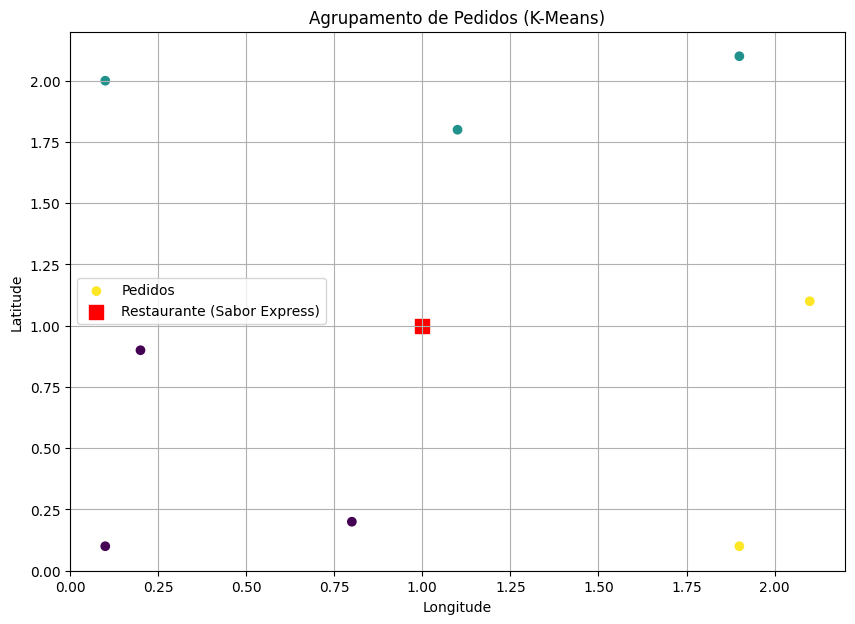


--- MAPEANDO PEDIDOS PARA O GRAFO ---
   id_pedido  cluster  no_mapa
0       1001        2        1
1       1002        1        3
2       1003        0        7
3       1004        1        9
4       1005        2        2
5       1006        0        8
6       1007        1        6
7       1008        0        4

--- FASE 2: CALCULANDO ROTAS OTIMIZADAS ---

--- Processando Entregador/Cluster 0 ---
Pontos de entrega (Nós): [np.int64(7), np.int64(8), np.int64(4)]
Rota Otimizada (Cluster 0): 5 -> 8 -> 7 -> 4 -> 5
Distância Total da Rota: 4.00 unidades


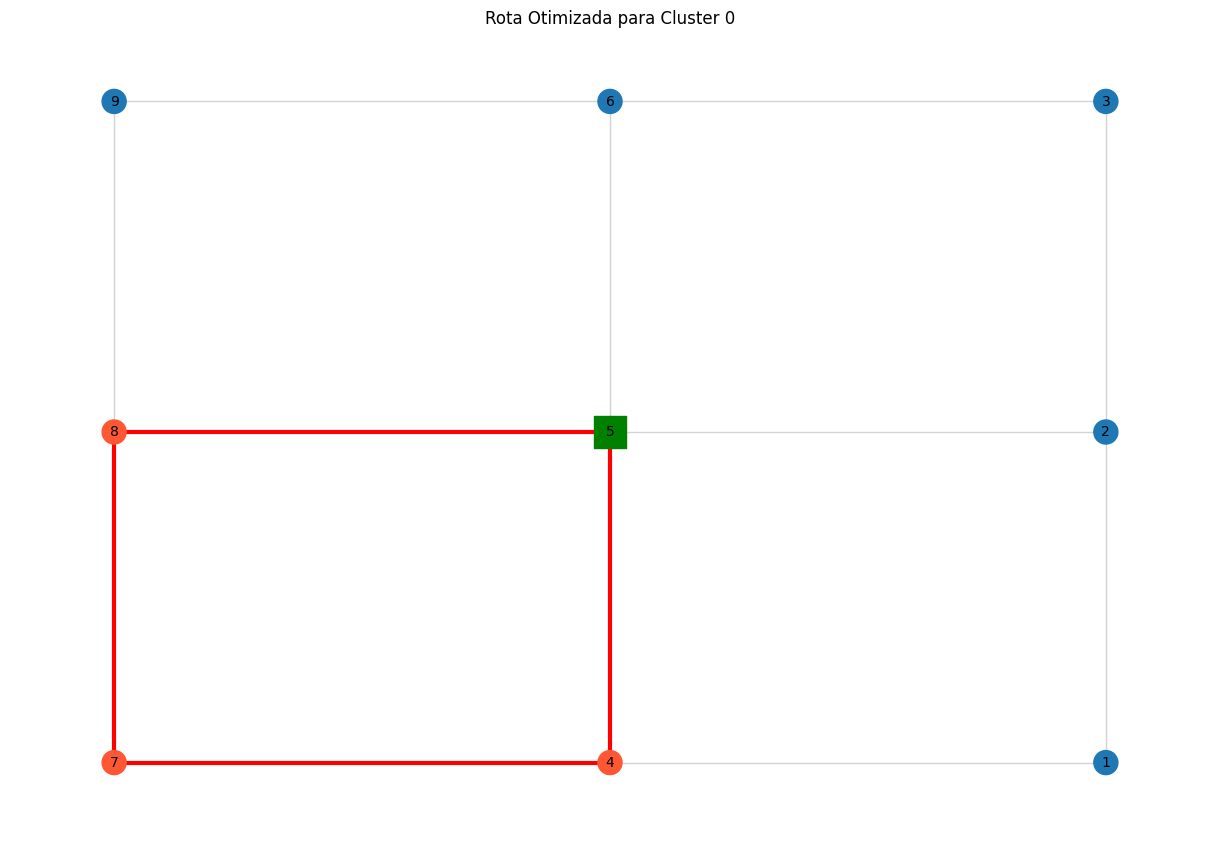


--- Processando Entregador/Cluster 1 ---
Pontos de entrega (Nós): [np.int64(3), np.int64(9), np.int64(6)]
Rota Otimizada (Cluster 1): 5 -> 6 -> 9 -> 3 -> 5
Distância Total da Rota: 6.00 unidades


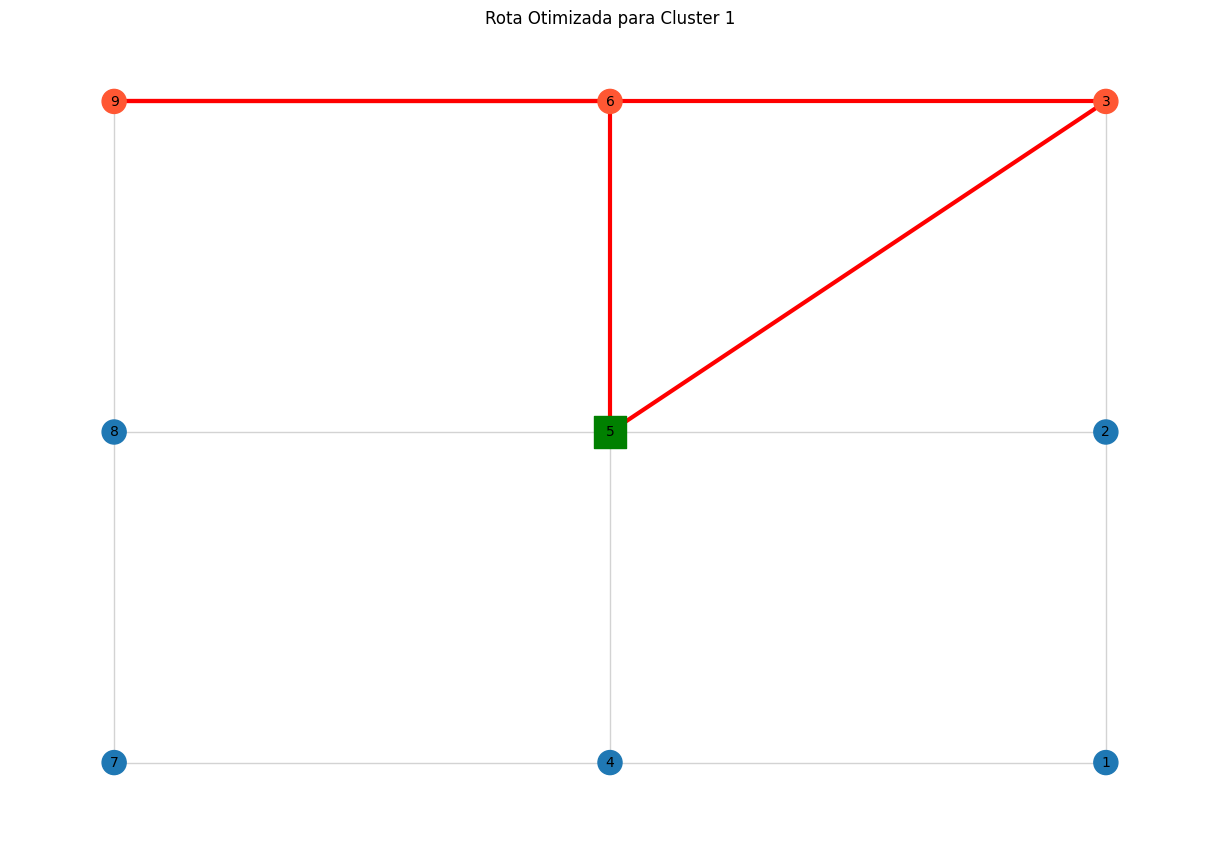


--- Processando Entregador/Cluster 2 ---
Pontos de entrega (Nós): [np.int64(1), np.int64(2)]
Rota Otimizada (Cluster 2): 5 -> 2 -> 1 -> 5
Distância Total da Rota: 4.00 unidades


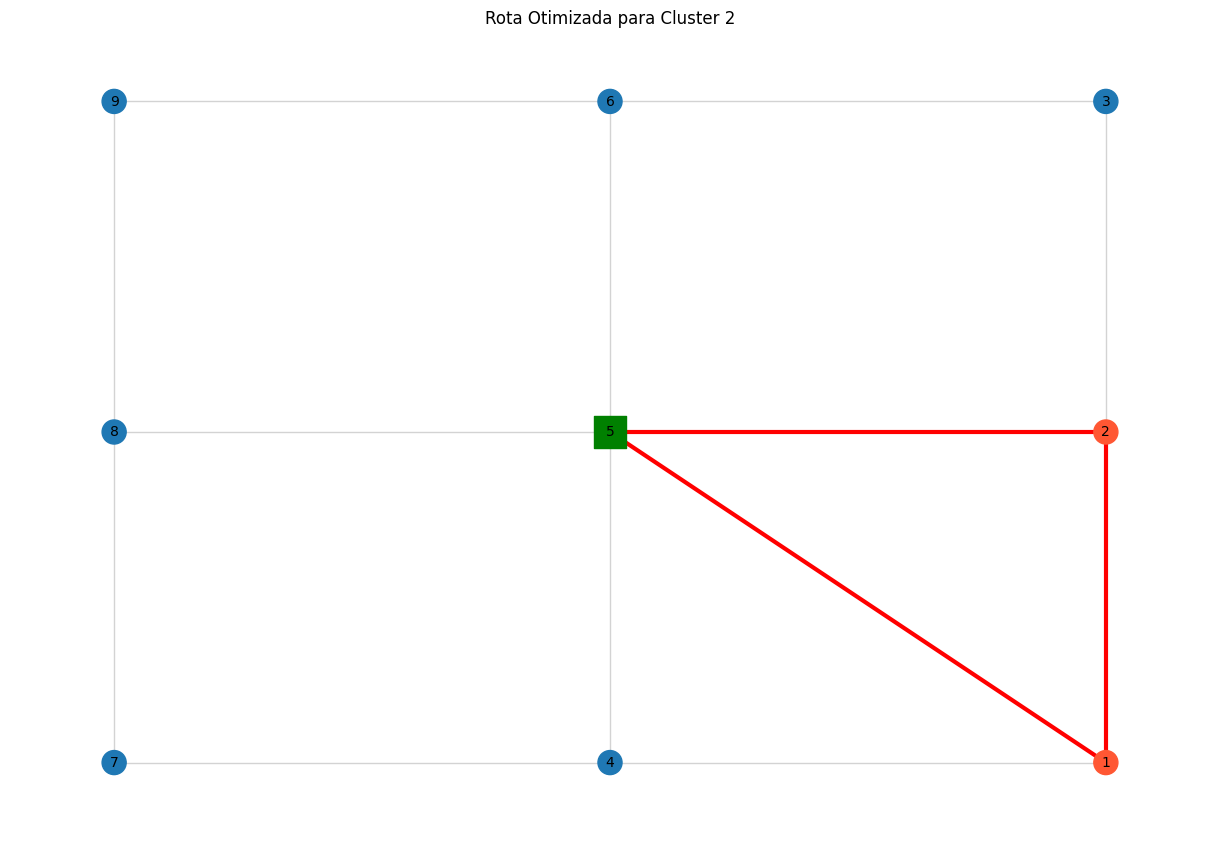


--- OTIMIZAÇÃO CONCLUÍDA ---


In [ ]:
# Célula 7: Execução Principal (main.py)

print("--- INICIANDO SOLUÇÃO ROTA INTELIGENTE ---")

# --- 1. Parâmetros ---
NUM_ENTREGADORES = 3
# O Sabor Express está no nó central do nosso mapa (Nó 5)
RESTAURANTE_NODE_ID = 5

# --- 2. Carregar Dados ---
G = carregar_grafo("data/nos_mapa.csv", "data/arestas_mapa.csv")
df_pedidos = pd.read_csv("data/pedidos_exemplo.csv")

# Posição (lon, lat) do restaurante para plotting
RESTAURANTE_POS = G.nodes[RESTAURANTE_NODE_ID]['pos']

# --- 3. Fase 1: Agrupamento (Clustering) ---
print("\n--- FASE 1: AGRUPANDO PEDIDOS ---")
df_pedidos_cluster = agrupar_pedidos(df_pedidos, NUM_ENTREGADORES)
visualizar_clusters(df_pedidos_cluster, RESTAURANTE_POS)

# --- 4. Encaixar Pedidos no Grafo ---
print("\n--- MAPEANDO PEDIDOS PARA O GRAFO ---")
# Para cada pedido (lat, lon), encontra o nó do mapa mais próximo
df_pedidos_cluster['no_mapa'] = df_pedidos_cluster.apply(
    lambda row: encontrar_no_mais_proximo(G, row['lat'], row['lon']),
    axis=1
)

print(df_pedidos_cluster[['id_pedido', 'cluster', 'no_mapa']])

# --- 5. Fase 2: Otimização de Rota (para cada cluster) ---
print("\n--- FASE 2: CALCULANDO ROTAS OTIMIZADAS ---")

for i in range(NUM_ENTREGADORES):
    print(f"\n--- Processando Entregador/Cluster {i} ---")

    # Pega os nós de entrega para este cluster
    pedidos_do_cluster = df_pedidos_cluster[df_pedidos_cluster['cluster'] == i]

    if pedidos_do_cluster.empty:
        print(f"Cluster {i} não tem pedidos.")
        continue

    # Pega os IDs únicos dos nós (pode haver múltiplos pedidos no mesmo nó)
    nos_para_visitar = list(pedidos_do_cluster['no_mapa'].unique())

    print(f"Pontos de entrega (Nós): {nos_para_visitar}")

    # Calcula a rota otimizada (Heurística TSP-NN + A*)
    rota_otimizada, custo_total = ordenar_rota_tsp_nn(G, nos_para_visitar, RESTAURANTE_NODE_ID)

    print(f"Rota Otimizada (Cluster {i}): {' -> '.join(map(str, rota_otimizada))}")
    print(f"Distância Total da Rota: {custo_total:.2f} unidades")

    # Visualizar a rota no grafo
    visualizar_rota_no_grafo(G, rota_otimizada, i)

print("\n--- OTIMIZAÇÃO CONCLUÍDA ---")

Eficiência e Resultados
A implementação combinada de K-Means e A* (com heurística TSP) transforma o processo de dispatch.

K-Means garante que os entregadores não cruzem a cidade, focando em zonas densas.

A* garante que a rota entre os pontos de entrega seja a mais rápida possível, considerando a estrutura real das ruas (arestas).

Impacto Esperado: Redução significativa no tempo total de entrega e economia de combustível.

Limitações Encontradas
Grafos Estáticos: A solução atual usa pesos fixos (distancia). Ela não considera o tráfego em tempo real, que pode alterar drasticamente o "custo" de uma rota.

"Encaixe" no Nó: Achar o "nó mais próximo" é uma simplificação. Em um mapa real, o ponto de entrega (ex: 123 Main St) é o nó.

Heurística Subótima: O "Vizinho Mais Próximo" é rápido, mas pode levar a rotas que não são as ideais.